02で前処理をしたデータの読み込みとモデルの学習を行うためのnotebookです。  
ここで作成したモデルは **src/models/** フォルダに格納して推論の際に使うようにして下さい。

## 必要なライブラリのimport

In [11]:
import warnings
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_curve, confusion_matrix, accuracy_score
from sklearn.utils import check_random_state
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import optuna.integration.lightgbm as lgbo
from lightgbm import early_stopping
from lightgbm import log_evaluation
from imblearn.under_sampling import RandomUnderSampler

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [12]:
# borutaでlightgbmを使うためのクラス
# https://qiita.com/studio_haneya/items/1366738e4a7b273fd1fd

class BorutaPyForLGB(BorutaPy):
    def __init__(self, estimator, n_estimators=1000, perc=100, alpha=0.05,
                 two_step=True, max_iter=100, random_state=None, verbose=0):
        super().__init__(estimator, n_estimators, perc, alpha,
                         two_step, max_iter, random_state, verbose)
        if random_state is None:
            self.random_state_input = np.random.randint(0, 2**64-1)
        elif isinstance(random_state, int):
            self.random_state_input = random_state
        else:
            raise TypeError('random_state must be int or None')

    def _get_tree_num(self, n_feat):
        depth = self.estimator.get_params()['max_depth']
        if (depth == None) or (depth <= 0):
            depth = 10
        f_repr = 100
        multi = ((n_feat * 2) / (np.sqrt(n_feat * 2) * depth))
        n_estimators = int(multi * f_repr)
        return n_estimators

    def _fit(self, X, y):
        # check input params
        # self._check_params(X, y)
        self.random_state = check_random_state(self.random_state)
        # setup variables for Boruta
        n_sample, n_feat = X.shape
        _iter = 1
        # holds the decision about each feature:
        # 0  - default state = tentative in original code
        # 1  - accepted in original code
        # -1 - rejected in original code
        dec_reg = np.zeros(n_feat, dtype=np.int64)
        # counts how many times a given feature was more important than
        # the best of the shadow features
        hit_reg = np.zeros(n_feat, dtype=np.int64)
        # these record the history of the iterations
        imp_history = np.zeros(n_feat, dtype=np.float64)
        sha_max_history = []

        # set n_estimators
        if self.n_estimators != 'auto':
            self.estimator.set_params(n_estimators=self.n_estimators)

        # main feature selection loop
        while np.any(dec_reg == 0) and _iter < self.max_iter:
            # find optimal number of trees and depth
            if self.n_estimators == 'auto':
                # number of features that aren't rejected
                not_rejected = np.where(dec_reg >= 0)[0].shape[0]
                n_tree = self._get_tree_num(not_rejected)
                self.estimator.set_params(n_estimators=n_tree)

            # make sure we start with a new tree in each iteration
            self.estimator.set_params(random_state=self.random_state_input)

            # add shadow attributes, shuffle them and train estimator, get imps
            cur_imp = self._add_shadows_get_imps(X, y, dec_reg)

            # get the threshold of shadow importances we will use for rejection
            imp_sha_max = np.percentile(cur_imp[1], self.perc)

            # record importance history
            sha_max_history.append(imp_sha_max)
            imp_history = np.vstack((imp_history, cur_imp[0]))

            # register which feature is more imp than the max of shadows
            hit_reg = self._assign_hits(hit_reg, cur_imp, imp_sha_max)

            # based on hit_reg we check if a feature is doing better than
            # expected by chance
            dec_reg = self._do_tests(dec_reg, hit_reg, _iter)

            # print out confirmed features
            if self.verbose > 0 and _iter < self.max_iter:
                self._print_results(dec_reg, _iter, 0)
            if _iter < self.max_iter:
                _iter += 1

        # we automatically apply R package's rough fix for tentative ones
        confirmed = np.where(dec_reg == 1)[0]
        tentative = np.where(dec_reg == 0)[0]
        # ignore the first row of zeros
        tentative_median = np.median(imp_history[1:, tentative], axis=0)
        # which tentative to keep
        tentative_confirmed = np.where(tentative_median
                                       > np.median(sha_max_history))[0]
        tentative = tentative[tentative_confirmed]

        # basic result variables
        self.n_features_ = confirmed.shape[0]
        self.support_ = np.zeros(n_feat, dtype=np.bool_)
        self.support_[confirmed] = 1
        self.support_weak_ = np.zeros(n_feat, dtype=np.bool_)
        self.support_weak_[tentative] = 1

        # ranking, confirmed variables are rank 1
        self.ranking_ = np.ones(n_feat, dtype=np.int64)
        # tentative variables are rank 2
        self.ranking_[tentative] = 2
        # selected = confirmed and tentative
        selected = np.hstack((confirmed, tentative))
        # all rejected features are sorted by importance history
        not_selected = np.setdiff1d(np.arange(n_feat), selected)
        # large importance values should rank higher = lower ranks -> *(-1)
        imp_history_rejected = imp_history[1:, not_selected] * -1

        # update rank for not_selected features
        if not_selected.shape[0] > 0:
                # calculate ranks in each iteration, then median of ranks across feats
                iter_ranks = self._nanrankdata(imp_history_rejected, axis=1)
                rank_medians = np.nanmedian(iter_ranks, axis=0)
                ranks = self._nanrankdata(rank_medians, axis=0)

                # set smallest rank to 3 if there are tentative feats
                if tentative.shape[0] > 0:
                    ranks = ranks - np.min(ranks) + 3
                else:
                    # and 2 otherwise
                    ranks = ranks - np.min(ranks) + 2
                self.ranking_[not_selected] = ranks
        else:
            # all are selected, thus we set feature supports to True
            self.support_ = np.ones(n_feat, dtype=np.bool_)

        # notify user
        if self.verbose > 0:
            self._print_results(dec_reg, _iter, 1)
        return self


In [13]:
# データの読み込み
train = pd.read_csv('../data/processed/processed20240621_train.csv')
# 目的変数と説明変数の作成
target = train['target']
del train['target']

In [14]:
errvalue = target.min()

特徴量選定とハイパラ調整（実行しなくてもOK）

In [15]:
# 文字列のカラムがあると特徴量選択とハイパラ調整でエラーが出るので、最初の決済月とカードIDを消す
train_ = train.drop('first_active_month', axis=1)
del train_['card_id']


In [16]:
X_train, X_test, y_train, y_test = train_test_split(train_, target, test_size=0.20, random_state=42)


# 特徴量選択なしの場合
model = lgb.LGBMRegressor(objective='regression',
                           metric='rmse',
                            num_leaves = 23,
                            learning_rate=0.1,
                            n_estimators=100,)
model.fit(X_train.values, y_train.values)

y_test_pred = model.predict(X_test.values)
y_test_pred = np.where(y_test_pred < -20, errvalue, y_test_pred)

print('SCORE with ALL Features: %1.2f\n' % mean_squared_error(y_test, y_test_pred))

# Borutaで特徴量選択 (一部書き換えたBorutaPyを使います)
model_f = lgb.LGBMRegressor(objective='regression',
                           metric='rmse',
                            num_leaves = 23,
                            learning_rate=0.1,
                            n_estimators=100,)
feat_selector = BorutaPyForLGB(model_f, n_estimators='auto', perc=80, max_iter=500, two_step=False,verbose=0, random_state=42)
feat_selector.fit(X_train.values, y_train.values)
print(train_.columns[feat_selector.support_])

# 選択したFeatureを取り出し
X_train_selected = X_train.iloc[:,feat_selector.support_]
X_test_selected = X_test.iloc[:,feat_selector.support_]

# 選択したFeatureで学習
model_f = lgb.LGBMRegressor(objective='regression',
                           metric='rmse',
                            num_leaves = 23,
                            learning_rate=0.1,
                            n_estimators=100,)
model_f.fit(X_train_selected.values, y_train.values)

y_test_pred_f = model_f.predict(X_test_selected.values)
y_test_pred_f = np.where(y_test_pred < -20, errvalue, y_test_pred)
print('SCORE with selected Features: %1.2f\n' % mean_squared_error(y_test, y_test_pred_f))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65747
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 327
[LightGBM] [Info] Start training from score -0.392633
SCORE with ALL Features: 13.69

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.376206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 131494
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 654
[LightGBM] [Info] Start training from score -0.392633
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.237544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 131494
[LightGBM] [Info] Number of data points in the train set: 161533, number of u

In [17]:
# optunaによるハイパーパラメータの探索


# 特徴量選択
train_selected = train_.iloc[:,feat_selector.support_]
# LightGBM用のデータセットに変換
trainval = lgb.Dataset(train_selected, target)

# ハイパーパラメータサーチ&モデル構築
params = {'objective': 'regression',
          'metric': 'rmse',
          'learning_rate': 0.1,
          'random_seed':0}

# クロスバリデーションによるハイパーパラメータの探索 3fold
tuner = lgbo.LightGBMTunerCV(params, trainval, callbacks=[early_stopping(100), log_evaluation(100)], folds=KFold(n_splits=5), optuna_seed=0)

# ハイパーパラメータ探索の実行
tuner.run()

# サーチしたパラメータの表示
best_params = tuner.best_params
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-21 10:55:30,023] A new study created in memory with name: no-name-ac9ec5f9-38b4-4b44-99b0-73008edfff89
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008496 seconds.
You can set `force_col_wis

feature_fraction, val_score: 3.676041:  14%|#4        | 1/7 [00:04<00:27,  4.64s/it]

Early stopping, best iteration is:
[81]	cv_agg's valid rmse: 3.67604 + 0.027587


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027277 seconds.
You can set `force_col_wis

feature_fraction, val_score: 3.672917:  29%|##8       | 2/7 [00:12<00:31,  6.34s/it]

Early stopping, best iteration is:
[110]	cv_agg's valid rmse: 3.67292 + 0.0281552


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011571 seconds.
You can set `force_col_wis

feature_fraction, val_score: 3.672917:  43%|####2     | 3/7 [00:17<00:23,  5.84s/it]

[200]	cv_agg's valid rmse: 3.67812 + 0.0251781
Early stopping, best iteration is:
[101]	cv_agg's valid rmse: 3.67418 + 0.0264561


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009513 seconds.
You can set `force_col_wis

feature_fraction, val_score: 3.672917:  57%|#####7    | 4/7 [00:21<00:15,  5.09s/it]

Early stopping, best iteration is:
[79]	cv_agg's valid rmse: 3.67383 + 0.0277531


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

feature_fraction, val_score: 3.672917:  71%|#######1  | 5/7 [00:24<00:09,  4.55s/it]

Early stopping, best iteration is:
[77]	cv_agg's valid rmse: 3.6774 + 0.0284297


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009414 seconds.
You can set `force_col_wis

feature_fraction, val_score: 3.672917:  86%|########5 | 6/7 [00:28<00:04,  4.27s/it]

Early stopping, best iteration is:
[72]	cv_agg's valid rmse: 3.67478 + 0.0256932


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010247 seconds.
You can set `force_col_wis

feature_fraction, val_score: 3.672917: 100%|##########| 7/7 [00:33<00:00,  4.72s/it]


[200]	cv_agg's valid rmse: 3.67875 + 0.0284059
Early stopping, best iteration is:
[102]	cv_agg's valid rmse: 3.67342 + 0.0292764


num_leaves, val_score: 3.672917:   0%|          | 0/20 [00:00<?, ?it/s]C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009744 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.672917:   5%|5         | 1/20 [00:06<01:57,  6.21s/it]

Early stopping, best iteration is:
[43]	cv_agg's valid rmse: 3.68962 + 0.0255089


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009933 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.672917:  10%|#         | 2/20 [00:13<02:01,  6.75s/it]

Early stopping, best iteration is:
[35]	cv_agg's valid rmse: 3.68937 + 0.0261011


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011172 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.672917:  15%|#5        | 3/20 [00:19<01:50,  6.49s/it]

Early stopping, best iteration is:
[32]	cv_agg's valid rmse: 3.69262 + 0.0274564


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009386 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.668011:  20%|##        | 4/20 [00:24<01:31,  5.72s/it]

Early stopping, best iteration is:
[242]	cv_agg's valid rmse: 3.66801 + 0.0251685


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009511 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.668011:  25%|##5       | 5/20 [00:28<01:19,  5.30s/it]

Early stopping, best iteration is:
[242]	cv_agg's valid rmse: 3.66801 + 0.0251685


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009759 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.668011:  30%|###       | 6/20 [00:33<01:10,  5.06s/it]

Early stopping, best iteration is:
[242]	cv_agg's valid rmse: 3.66801 + 0.0251685


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010281 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.668011:  35%|###5      | 7/20 [00:37<01:04,  4.97s/it]

Early stopping, best iteration is:
[242]	cv_agg's valid rmse: 3.66801 + 0.0251685


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013058 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.668011:  40%|####      | 8/20 [00:42<00:57,  4.81s/it]

Early stopping, best iteration is:
[42]	cv_agg's valid rmse: 3.68168 + 0.0275609


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009533 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.668011:  45%|####5     | 9/20 [00:50<01:05,  5.95s/it]

Early stopping, best iteration is:
[23]	cv_agg's valid rmse: 3.69098 + 0.025862


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010819 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.668011:  50%|#####     | 10/20 [00:56<00:58,  5.82s/it]

Early stopping, best iteration is:
[60]	cv_agg's valid rmse: 3.67798 + 0.0252623


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011634 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.668011:  55%|#####5    | 11/20 [01:02<00:54,  6.02s/it]

Early stopping, best iteration is:
[59]	cv_agg's valid rmse: 3.68051 + 0.0256906


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010456 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.668011:  60%|######    | 12/20 [01:07<00:45,  5.66s/it]

Early stopping, best iteration is:
[82]	cv_agg's valid rmse: 3.67724 + 0.0282816


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025743 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.668011:  65%|######5   | 13/20 [01:13<00:40,  5.79s/it]

Early stopping, best iteration is:
[47]	cv_agg's valid rmse: 3.68526 + 0.0257829


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010897 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.668011:  70%|#######   | 14/20 [01:23<00:41,  6.86s/it]

[1000]	cv_agg's valid rmse: 3.73275 + 0.030841
Did not meet early stopping. Best iteration is:
[999]	cv_agg's valid rmse: 3.73274 + 0.0308534


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010915 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.668011:  75%|#######5  | 15/20 [01:27<00:30,  6.14s/it]

Early stopping, best iteration is:
[99]	cv_agg's valid rmse: 3.67241 + 0.0262978


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010706 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.668011:  80%|########  | 16/20 [01:31<00:22,  5.57s/it]

Early stopping, best iteration is:
[68]	cv_agg's valid rmse: 3.67491 + 0.0309449


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010646 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.668011:  85%|########5 | 17/20 [01:38<00:17,  5.95s/it]

[500]	cv_agg's valid rmse: 3.67162 + 0.0266581
Early stopping, best iteration is:
[408]	cv_agg's valid rmse: 3.67072 + 0.0262025


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011876 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.668011:  90%|######### | 18/20 [01:43<00:11,  5.53s/it]

Early stopping, best iteration is:
[67]	cv_agg's valid rmse: 3.67759 + 0.0276055


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011149 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.668011:  95%|#########5| 19/20 [01:49<00:05,  5.80s/it]

Early stopping, best iteration is:
[48]	cv_agg's valid rmse: 3.68417 + 0.0225045


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011846 seconds.
You can set `force_col_wis

num_leaves, val_score: 3.668011: 100%|##########| 20/20 [01:54<00:00,  5.72s/it]

[200]	cv_agg's valid rmse: 3.67634 + 0.0269037
Early stopping, best iteration is:
[111]	cv_agg's valid rmse: 3.6708 + 0.0282929



bagging, val_score: 3.668011:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012210 seconds.
You can set `force_col_wis

bagging, val_score: 3.668011:  10%|#         | 1/10 [00:04<00:37,  4.20s/it]

Early stopping, best iteration is:
[221]	cv_agg's valid rmse: 3.67457 + 0.0272184


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010547 seconds.
You can set `force_col_wis

bagging, val_score: 3.668011:  10%|#         | 1/10 [00:09<00:37,  4.20s/it]

[300]	cv_agg's valid rmse: 3.66894 + 0.0260425
Early stopping, best iteration is:
[213]	cv_agg's valid rmse: 3.66803 + 0.0266421


bagging, val_score: 3.668011:  20%|##        | 2/10 [00:09<00:39,  4.98s/it]C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013577 seconds.
You can set `force_col_wis

bagging, val_score: 3.668011:  30%|###       | 3/10 [00:16<00:41,  5.91s/it]

Early stopping, best iteration is:
[299]	cv_agg's valid rmse: 3.67089 + 0.0263297


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010607 seconds.
You can set `force_col_wis

bagging, val_score: 3.668011:  40%|####      | 4/10 [00:20<00:30,  5.17s/it]

[300]	cv_agg's valid rmse: 3.68022 + 0.0228637
Early stopping, best iteration is:
[214]	cv_agg's valid rmse: 3.67823 + 0.0235955


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013546 seconds.
You can set `force_col_wis

bagging, val_score: 3.668011:  50%|#####     | 5/10 [00:26<00:27,  5.47s/it]

Early stopping, best iteration is:
[282]	cv_agg's valid rmse: 3.67081 + 0.0266237


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010651 seconds.
You can set `force_col_wis

bagging, val_score: 3.668011:  60%|######    | 6/10 [00:32<00:21,  5.43s/it]

Early stopping, best iteration is:
[228]	cv_agg's valid rmse: 3.67149 + 0.0266046


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011385 seconds.
You can set `force_col_wis

bagging, val_score: 3.667047:  70%|#######   | 7/10 [00:39<00:18,  6.07s/it]

Early stopping, best iteration is:
[273]	cv_agg's valid rmse: 3.66705 + 0.0262964


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010956 seconds.
You can set `force_col_wis

bagging, val_score: 3.667047:  80%|########  | 8/10 [00:46<00:12,  6.31s/it]

Early stopping, best iteration is:
[247]	cv_agg's valid rmse: 3.66797 + 0.0269846


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013360 seconds.
You can set `force_col_wis

bagging, val_score: 3.667047:  90%|######### | 9/10 [00:53<00:06,  6.52s/it]

Early stopping, best iteration is:
[244]	cv_agg's valid rmse: 3.66892 + 0.0253817


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014449 seconds.
You can set `force_col_wis

bagging, val_score: 3.667047: 100%|##########| 10/10 [01:00<00:00,  6.09s/it]


[400]	cv_agg's valid rmse: 3.67221 + 0.0276669
Early stopping, best iteration is:
[304]	cv_agg's valid rmse: 3.67073 + 0.0270484


feature_fraction_stage2, val_score: 3.667047:   0%|          | 0/6 [00:00<?, ?it/s]C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016377 seconds.
You can set `force_col_wis

feature_fraction_stage2, val_score: 3.667047:  17%|#6        | 1/6 [00:08<00:41,  8.30s/it]

Early stopping, best iteration is:
[295]	cv_agg's valid rmse: 3.66885 + 0.0256947


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010055 seconds.
You can set `force_col_wis

feature_fraction_stage2, val_score: 3.667047:  33%|###3      | 2/6 [00:15<00:30,  7.54s/it]

Early stopping, best iteration is:
[232]	cv_agg's valid rmse: 3.6702 + 0.0235559


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014614 seconds.
You can set `force_col_wis

feature_fraction_stage2, val_score: 3.667047:  50%|#####     | 3/6 [00:23<00:23,  7.75s/it]

Early stopping, best iteration is:
[276]	cv_agg's valid rmse: 3.66903 + 0.0266097


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013376 seconds.
You can set `force_col_wis

feature_fraction_stage2, val_score: 3.667047:  67%|######6   | 4/6 [00:30<00:14,  7.47s/it]

Early stopping, best iteration is:
[221]	cv_agg's valid rmse: 3.66981 + 0.0251344


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012010 seconds.
You can set `force_col_wis

feature_fraction_stage2, val_score: 3.667047:  83%|########3 | 5/6 [00:38<00:07,  7.79s/it]

Early stopping, best iteration is:
[273]	cv_agg's valid rmse: 3.66705 + 0.0262964


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013069 seconds.
You can set `force_col_wis

feature_fraction_stage2, val_score: 3.667047: 100%|##########| 6/6 [00:48<00:00,  8.14s/it]


Early stopping, best iteration is:
[354]	cv_agg's valid rmse: 3.66967 + 0.026139


regularization_factors, val_score: 3.667047:   0%|          | 0/20 [00:00<?, ?it/s]C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016237 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.666944:   5%|5         | 1/20 [00:08<02:37,  8.27s/it]

Early stopping, best iteration is:
[251]	cv_agg's valid rmse: 3.66694 + 0.0267619


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014423 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.666944:  10%|#         | 2/20 [00:17<02:38,  8.81s/it]

Early stopping, best iteration is:
[288]	cv_agg's valid rmse: 3.66735 + 0.0252839


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023174 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.665656:  15%|#5        | 3/20 [00:26<02:33,  9.02s/it]

Early stopping, best iteration is:
[280]	cv_agg's valid rmse: 3.66566 + 0.0247671


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013314 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.664756:  20%|##        | 4/20 [00:37<02:34,  9.67s/it]

Early stopping, best iteration is:
[347]	cv_agg's valid rmse: 3.66476 + 0.0243164


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013239 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.664756:  25%|##5       | 5/20 [00:47<02:28,  9.90s/it]

Early stopping, best iteration is:
[335]	cv_agg's valid rmse: 3.66579 + 0.0244929


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014322 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.664756:  30%|###       | 6/20 [00:56<02:11,  9.40s/it]

Early stopping, best iteration is:
[246]	cv_agg's valid rmse: 3.66659 + 0.0260676


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017194 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.664756:  35%|###5      | 7/20 [01:04<01:59,  9.21s/it]

Early stopping, best iteration is:
[267]	cv_agg's valid rmse: 3.66637 + 0.0259428


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015952 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.664756:  40%|####      | 8/20 [01:15<01:56,  9.68s/it]

Early stopping, best iteration is:
[351]	cv_agg's valid rmse: 3.66658 + 0.0263682


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014121 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.664756:  45%|####5     | 9/20 [01:25<01:47,  9.78s/it]

Early stopping, best iteration is:
[326]	cv_agg's valid rmse: 3.66592 + 0.0249886


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016043 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.664756:  50%|#####     | 10/20 [01:35<01:37,  9.78s/it]

Early stopping, best iteration is:
[297]	cv_agg's valid rmse: 3.66697 + 0.0247294


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012972 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.664756:  55%|#####5    | 11/20 [01:45<01:28,  9.88s/it]

Early stopping, best iteration is:
[314]	cv_agg's valid rmse: 3.66655 + 0.0251632


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014389 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.664756:  60%|######    | 12/20 [01:55<01:19,  9.99s/it]

Early stopping, best iteration is:
[326]	cv_agg's valid rmse: 3.66498 + 0.0253763


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016074 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.664756:  65%|######5   | 13/20 [02:04<01:07,  9.68s/it]

Early stopping, best iteration is:
[272]	cv_agg's valid rmse: 3.66682 + 0.0264211


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012334 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.664756:  70%|#######   | 14/20 [02:13<00:56,  9.35s/it]

Early stopping, best iteration is:
[254]	cv_agg's valid rmse: 3.66715 + 0.0251267


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014324 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.664756:  75%|#######5  | 15/20 [02:21<00:45,  9.15s/it]

Early stopping, best iteration is:
[256]	cv_agg's valid rmse: 3.66744 + 0.0268068


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017416 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.664756:  80%|########  | 16/20 [02:30<00:35,  8.96s/it]

Early stopping, best iteration is:
[226]	cv_agg's valid rmse: 3.66889 + 0.0276024


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018454 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.664756:  85%|########5 | 17/20 [02:40<00:27,  9.15s/it]

Early stopping, best iteration is:
[286]	cv_agg's valid rmse: 3.66659 + 0.0260378


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014444 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.664756:  90%|######### | 18/20 [02:50<00:18,  9.45s/it]

Early stopping, best iteration is:
[329]	cv_agg's valid rmse: 3.66635 + 0.0258381


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017043 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.664756:  95%|#########5| 19/20 [02:58<00:09,  9.18s/it]

Early stopping, best iteration is:
[257]	cv_agg's valid rmse: 3.66725 + 0.0255629


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014006 seconds.
You can set `force_col_wis

regularization_factors, val_score: 3.664756: 100%|##########| 20/20 [03:08<00:00,  9.42s/it]


[400]	cv_agg's valid rmse: 3.66793 + 0.0252895
Early stopping, best iteration is:
[300]	cv_agg's valid rmse: 3.66657 + 0.0255863


min_child_samples, val_score: 3.664756:   0%|          | 0/5 [00:00<?, ?it/s]C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012760 seconds.
You can set `force_col_wis

min_child_samples, val_score: 3.664290:  20%|##        | 1/5 [00:09<00:36,  9.21s/it]

Early stopping, best iteration is:
[279]	cv_agg's valid rmse: 3.66429 + 0.0256625


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016902 seconds.
You can set `force_col_wis

min_child_samples, val_score: 3.664290:  40%|####      | 2/5 [00:19<00:29,  9.94s/it]

Early stopping, best iteration is:
[337]	cv_agg's valid rmse: 3.66498 + 0.0250996


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016883 seconds.
You can set `force_col_wis

min_child_samples, val_score: 3.664290:  60%|######    | 3/5 [00:29<00:19,  9.92s/it]

Early stopping, best iteration is:
[323]	cv_agg's valid rmse: 3.66671 + 0.0261323


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014016 seconds.
You can set `force_col_wis

min_child_samples, val_score: 3.664290:  80%|########  | 4/5 [00:37<00:09,  9.30s/it]

Early stopping, best iteration is:
[247]	cv_agg's valid rmse: 3.66656 + 0.0251336


C:\Users\fumika.sambe.su\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8665
[LightGBM] [Info] Number of data points in the train set: 161534, number of used features: 37
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012823 seconds.
You can set `force_col_wis

min_child_samples, val_score: 3.664290: 100%|##########| 5/5 [00:48<00:00,  9.63s/it]

Early stopping, best iteration is:
[336]	cv_agg's valid rmse: 3.66436 + 0.0271613
  Params: 
    objective: regression
    metric: rmse
    learning_rate: 0.1
    random_seed: 0
    feature_pre_filter: False
    lambda_l1: 1.7779192477352463e-08
    lambda_l2: 8.04639647011756
    num_leaves: 7
    feature_fraction: 0.6
    bagging_fraction: 0.999528917168157
    bagging_freq: 5
    min_child_samples: 50


In [9]:
# 特徴量の情報
features = [c for c in train_selected.columns if c not in ['card_id', 'first_active_month']]
# categorical_feats = ['feature_2', 'feature_3']

ここから実行すればOK

In [6]:
best_params = {'objective': 'regression',
 'metric': 'rmse',
 'learning_rate': 0.1,
 'random_seed': 0,
 'feature_pre_filter': False,
 'lambda_l1': 1.7779192477352463e-08,
 'lambda_l2': 8.04639647011756,
 'num_leaves': 7,
 'feature_fraction': 0.6,
 'bagging_fraction': 0.999528917168157,
 'bagging_freq': 5,
 'min_child_samples': 50}

In [ ]:
features = ['elapsed_time', 'hist_category_1_sum', 'hist_installments_sum',
 'hist_purchase_date_ptp', 'hist_purchase_date_min', 'hist_month_diff_mean',
 'hist_merchant_avg_purchases_lag3_sum', 'hist_merchant_active_months_lag12_sum',
 'auth_category_1_sum', 'auth_category_1_mean', 'auth_purchase_amount_sum',
 'auth_installments_sum', 'auth_purchase_month_std', 'auth_purchase_date_ptp',
 'auth_purchase_date_min', 'auth_purchase_date_max', 'auth_month_lag_mean',
 'auth_month_diff_mean', 'auth_merchant_group_id_nunique',
 'auth_merchant_avg_purchases_lag3_min', 'new_category_1_sum',
 'new_category_1_mean', 'new_purchase_amount_sum', 'new_purchase_amount_mean',
 'new_purchase_amount_max', 'new_purchase_amount_std', 'new_purchase_month_mean',
 'new_purchase_date_ptp', 'new_purchase_date_min', 'new_purchase_date_max',
 'new_month_lag_mean', 'new_merchant_avg_purchases_lag6_sum', 'month_lag_std',
 'purchase_amount_count_mean', 'purchase_amount_mean_mean',
 'purchase_amount_max_mean', 'authorized_flag_mean']

In [24]:
#lightgbm
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=0)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
        label=target.iloc[trn_idx],
    )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
        label=target.iloc[val_idx],
    )
    num_round = 10000
    clf = lgb.train(params=best_params,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                            lgb.log_evaluation(100)])

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    with open(f'../src/models/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)


fold n°0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8637
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Start training from score -0.393503
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.65206
[200]	valid_0's rmse: 3.64334
[300]	valid_0's rmse: 3.64127
[400]	valid_0's rmse: 3.64076
[500]	valid_0's rmse: 3.64141
[600]	valid_0's rmse: 3.64052
Early stopping, best iteration is:
[453]	valid_0's rmse: 3.64002
fold n°1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8643
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Start training from sco

In [25]:
oof = np.where(oof < -17, errvalue, oof)
print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

CV score: 3.66897 


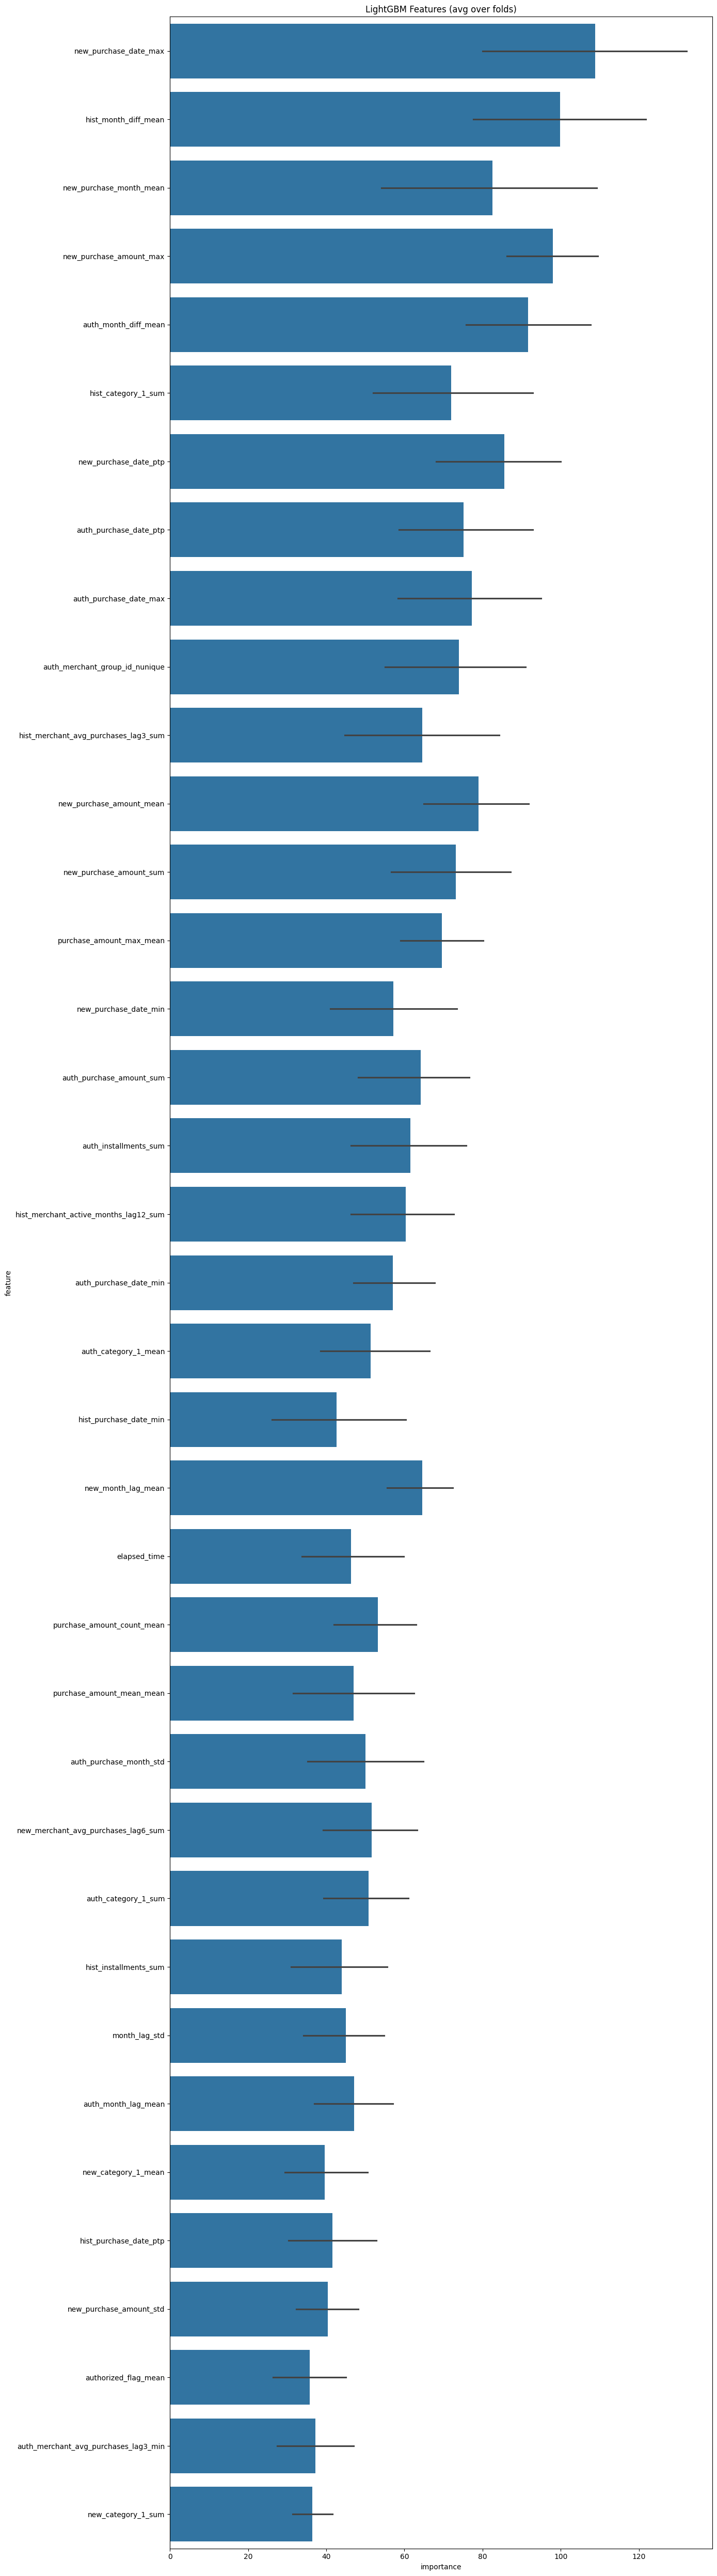

In [26]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')